In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Load data
df = pd.read_csv("Airmean_chennai.csv")

# Optional: Extract only relevant columns
timedata = pd.DataFrame()
timedata["Date"] = df["Date"]
timedata["AQI"] = df["AQI"]

# Convert AQI to numeric if needed
df["AQI"] = pd.to_numeric(df["AQI"], errors='coerce')
df = df.dropna()

# Split data
df_train = df["AQI"].head(1500)
df_test = df["AQI"].tail(509)

# Define orders to test (p, d, q, P, D, Q, s)
orders = [(0, 0, 0, 0, 0, 0, 0), 
          (0, 0, 1, 0, 0, 0, 0), 
          (2, 0, 1, 0, 0, 0, 0), 
          (1, 1, 1, 1, 1, 1, 12)]  # include one seasonal config

orderslist = []
rscorelist = []

for i in orders:
    p,d,q,P,D,Q,s = i
    orderslist.append(i)
    
    try:
        model = SARIMAX(df_train, 
                        order=(p,d,q), 
                        seasonal_order=(P,D,Q,s), 
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()
        
        y_pred = model.predict(start=len(df_train), end=len(df)-1)
        
        r2 = r2_score(df_test, y_pred)
        rscorelist.append(r2)
        print(f"Order={i}, R2 Score={r2:.4f}")
    
    except Exception as e:
        print(f"Failed for order {i}: {e}")
        rscorelist.append(None)

# Create result DataFrame
result = pd.DataFrame()
result["Order"] = orderslist
result["R_score"] = rscorelist
print(result)


Order=(0, 0, 0, 0, 0, 0, 0), R2 Score=-6.4103
Order=(0, 0, 1, 0, 0, 0, 0), R2 Score=-6.4059
Order=(2, 0, 1, 0, 0, 0, 0), R2 Score=-0.0751
Order=(1, 1, 1, 1, 1, 1, 12), R2 Score=-0.2440
                    Order   R_score
0   (0, 0, 0, 0, 0, 0, 0) -6.410263
1   (0, 0, 1, 0, 0, 0, 0) -6.405886
2   (2, 0, 1, 0, 0, 0, 0) -0.075089
3  (1, 1, 1, 1, 1, 1, 12) -0.243966


In [5]:
# PREDICTION
best_order = orders[rscorelist.index(max([r for r in rscorelist if r is not None]))]
p,d,q,P,D,Q,s = best_order

final_model = SARIMAX(df["AQI"], 
                      order=(p,d,q), 
                      seasonal_order=(P,D,Q,s)).fit()

future_pred = final_model.predict(start=len(df), end=len(df)+4)
print("Next 5 YEARS AQI forecast:")
print(future_pred)


Next 5 YEARS AQI forecast:
2009    91.395869
2010    91.028728
2011    90.803676
2012    90.663816
2013    90.575035
Name: predicted_mean, dtype: float64


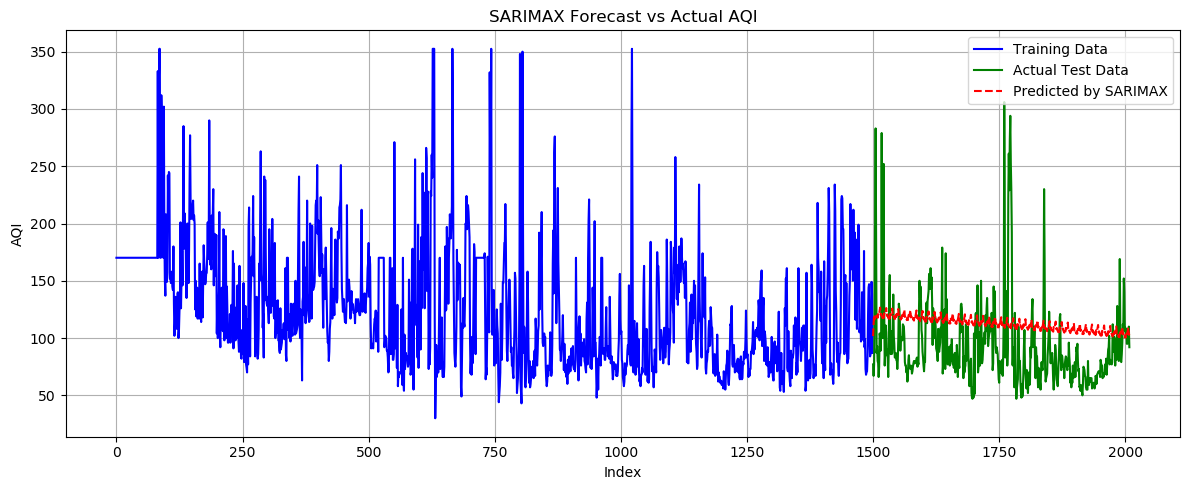

In [3]:
# ACTUAL AND PREDICTED PLOT
import matplotlib.pyplot as plt

# Combine index for alignment
test_index = df.tail(len(df_test)).index

plt.figure(figsize=(12, 5))
plt.plot(df_train.index, df_train, label='Training Data', color='blue')
plt.plot(test_index, df_test, label='Actual Test Data', color='green')
plt.plot(test_index, y_pred, label='Predicted by SARIMAX', color='red', linestyle='--')

plt.title("SARIMAX Forecast vs Actual AQI")
plt.xlabel("Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


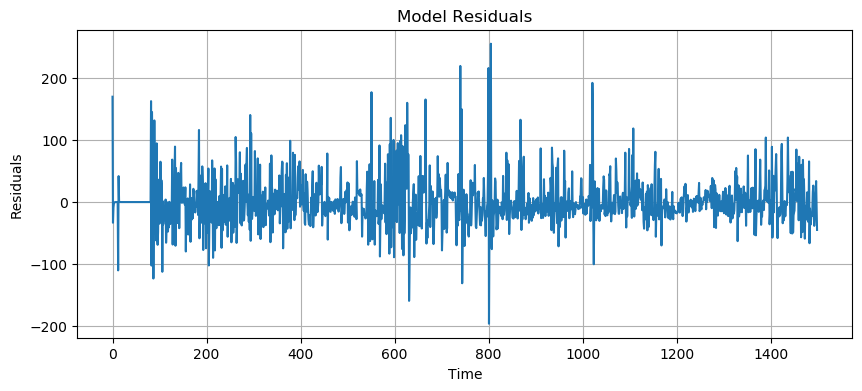

ADF Statistic: -11.728325648994664
p-value: 1.3605967341811137e-21
✅ Residuals are stationary → model is well-fitted


In [4]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def check_residual_stationarity(model):
    residuals = model.resid
    
    # Plot residuals
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title("Model Residuals")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()
    
    # ADF Test
    result = adfuller(residuals.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    
    if result[1] < 0.05:
        print("✅ Residuals are stationary → model is well-fitted")
    else:
        print("❌ Residuals are NOT stationary → model may be missing trends")

# Example after SARIMAX model is fit:
# model = SARIMAX(...).fit()
check_residual_stationarity(model)
